# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Environment and the Architecture of the Policy

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)



observation space: Box(4,)
action space: Discrete(2)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, state_size=4, hidden_size=16, action_size=2):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        self.net = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        probs = self.net(x)
        return probs

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self(state).cpu()
        distribution = Categorical(probs)
        action = distribution.sample()
        return action.item(), distribution.log_prob(action)


### 3. Train the Agent with REINFORCE

In [7]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(num_episodes=1000, num_steps=1000, gamma=1):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, num_episodes+1):
        log_probs = []
        rewards = []
        state = env.reset()

        for t in range(num_steps):
            action, log_prob = policy.act(state)
            state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            if done: break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma * i for i in range(len(rewards))]
        G = sum([a * b for a, b in zip(discounts, rewards)])

        policy_loss = sum([-log_prob * G for log_prob in log_probs])

        # policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % 100 == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores


### 4. Plot the Scores

Episode 100	Average Score: 36.44
Episode 200	Average Score: 61.59
Episode 300	Average Score: 23.62
Episode 400	Average Score: 38.05
Episode 500	Average Score: 165.41
Episode 600	Average Score: 179.47
Episode 700	Average Score: 179.17
Environment solved in 670 episodes!	Average Score: 196.05


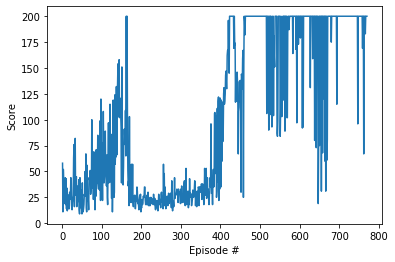

In [8]:
scores = reinforce()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [5]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()